In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
device = torch.device("cuda" 
                      if torch.cuda.is_available() 
                      else "cpu")

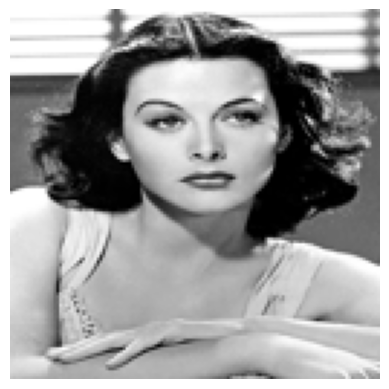

In [3]:
img_originale = transforms.ToTensor()(Image.open('Hedylamarr.jpg').convert('L').resize((128, 128)))
plt.imshow(img_originale.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

In [4]:
reale_img_tensor = img_originale.unsqueeze(0).to(device)

In [5]:
noisy_img_tensor = torch.poisson(reale_img_tensor.clone() * 255.0) / 255.0
noisy_img_tensor = torch.clamp(noisy_img_tensor, 0.0, 1.0)

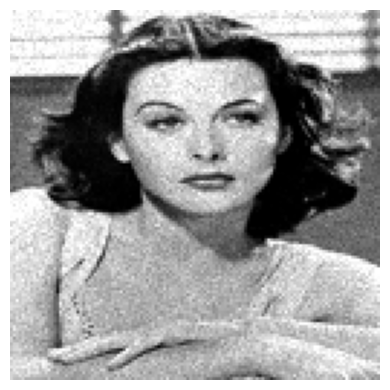

In [21]:
noisy_img_plt = noisy_img_tensor.detach().cpu().squeeze().numpy()
fig, axs1 = plt.subplots(1, 1, figsize=(4, 4))
axs1.imshow(noisy_img_plt, cmap='gray', vmin=0, vmax=1)
axs1.axis('off')
plt.tight_layout()
plt.show()

In [7]:
class Generatore(nn.Module):   
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.PReLU(),  #per stabilizzare uscita 
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.PReLU() # stride si muove di 2 pixel; riduce la dimensione dell’immagine
        )
        self.middle = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1), nn.PReLU() 
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.PReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.PReLU(),
            nn.ConvTranspose2d(64, 1, 4, 2, 1), nn.Sigmoid()  # Sigmoid outputs come img in scala di grigi
        )

    def forward(self, x): #img con rumore
        enc = self.encoder(x)
        mid = self.middle(enc)
        dec = self.decoder(mid)
        return dec

In [8]:
class Discriminatore(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),  
            nn.Conv2d(256, 1, 4, 1, 0)  # Output is a single channel feature map
        )

    def forward(self, x):
        x = self.features(x) # passa l’immagine in vari layer
        return torch.sigmoid(x.mean(dim=[2, 3], keepdim=True)) # fa la mean su tuuta img, la prob che sia vera 


G = Generatore().to(device)
D = Discriminatore().to(device)

In [9]:
critereGAN = nn.BCELoss()  #  cross entropy per GAN per classificazione binaria
criterepixel = nn.MSELoss() 

In [10]:
ottimizzazione_G = torch.optim.Adam(G.parameters(), lr=2e-4)
ottimizzazione_D = torch.optim.Adam(D.parameters(), lr=2e-4)

Epoch [100/1000], Loss Discriminatore: 0.6753, Loss Generatore: 0.0022
Epoch [200/1000], Loss Discriminatore: 0.6876, Loss Generatore: 0.0009
Epoch [300/1000], Loss Discriminatore: 0.6883, Loss Generatore: 0.0008
Epoch [400/1000], Loss Discriminatore: 0.6903, Loss Generatore: 0.0007
Epoch [500/1000], Loss Discriminatore: 0.6926, Loss Generatore: 0.0007
Epoch [600/1000], Loss Discriminatore: 0.6931, Loss Generatore: 0.0007
Epoch [700/1000], Loss Discriminatore: 0.6913, Loss Generatore: 0.0008
Epoch [800/1000], Loss Discriminatore: 0.6937, Loss Generatore: 0.0007
Epoch [900/1000], Loss Discriminatore: 0.6930, Loss Generatore: 0.0007
Epoch [1000/1000], Loss Discriminatore: 0.6934, Loss Generatore: 0.0007


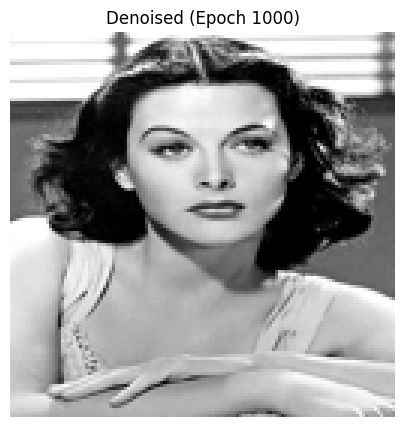

In [11]:
iterazioni = 1000  
lossD = []
lossG = []
batch_size = reale_img_tensor.size(0)
reale_label = torch.ones(batch_size, 1, 1, 1).to(device)  # Shape adaptée au discriminateur
fake_label = torch.zeros(batch_size, 1, 1, 1).to(device)  # Shape adaptée au discriminateur

for epoch in range(iterazioni):
    ottimizzazione_D.zero_grad()
    
    reale_output = D(reale_img_tensor) # metti immagine vera nel D
    loss_D_reale = critereGAN(reale_output, reale_label) # confronta con etichetta 1

    # Fake images
    fake_img = G(noisy_img_tensor) # genera img pulita dal rumore
    fake_output = D(fake_img.detach()) #metti immagine generata nel D 
    loss_D_fake = critereGAN(fake_output, fake_label) # confronta con etichetta 0

    loss_D = (loss_D_reale + loss_D_fake) / 2 #media di due errori 
    loss_D.backward()  
    ottimizzazione_D.step()

    #entrainée G
    ottimizzazione_G.zero_grad()
    fake_output_per_G_loss = D(fake_img)
    loss_G_GAN = critereGAN(fake_output_per_G_loss, reale_label)
    loss_G_pixel = criterepixel(fake_img, reale_img_tensor)  #confronta img generata con img reale pixel*pixel

    loss_G =  0.001 * loss_G_GAN +  0.999 * loss_G_pixel #lambda_gan = 0.001 e lambda_pixel per errore = 0.999 
    loss_G.backward()
    ottimizzazione_G.step()

    lossD.append(loss_D.item())
    lossG.append(loss_G.item())

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{iterazioni}], Loss Discriminatore: {loss_D.item():.4f}, Loss Generatore: {loss_G.item():.4f}")

finale_denoised_img = fake_img.detach().cpu().squeeze().numpy()

plt.figure(figsize=(5, 5))
plt.imshow(finale_denoised_img, cmap='gray')
plt.title(f"Denoised (Epoch {iterazioni})")
plt.axis('off')
plt.show()

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

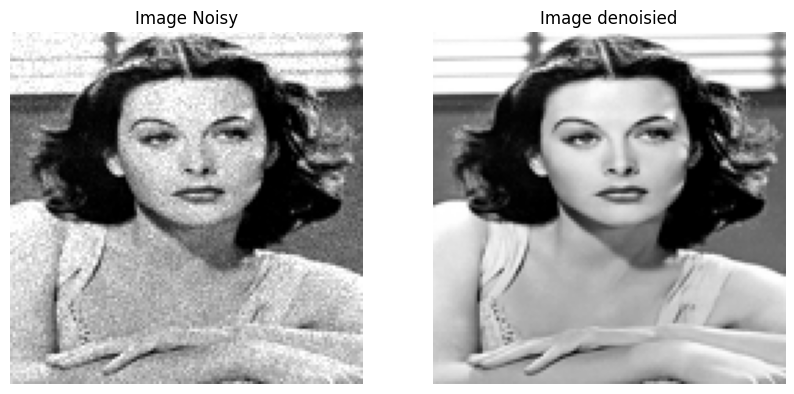

In [18]:
imgfinale = G(noisy_img_tensor).detach().cpu().squeeze().numpy()
noisy_img_plt = noisy_img_tensor.detach().cpu().squeeze().numpy()

fig2, axs2 = plt.subplots(1, 2, figsize=(10, 6))
axs2[0].imshow(noisy_img_plt, cmap='gray')
axs2[0].set_title('Image Noisy')
axs2[0].axis('off')

axs2[1].imshow(imgfinale, cmap='gray')
axs2[1].set_title('Image denoisied')
axs2[1].axis('off')

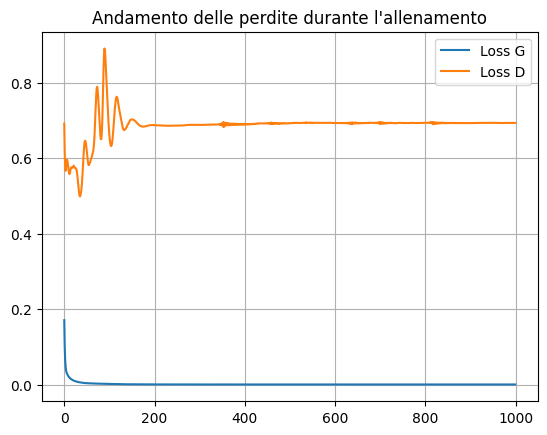

In [20]:
plt.plot(lossG, label='Loss G')
plt.plot(lossD, label='Loss D')
plt.legend()
plt.title("Andamento delle perdite durante l'allenamento")
plt.grid(True)
plt.show()